# Data Pre-processing

- Part I: Image Processing
        - Train-dev-test split
        - Resize Images
        - Data Augmentation
        
- Part II: Generate HDF5 Files    
        - Convert to numpy data
        - Generate H5 Data
        - Check H5 Data
        
Suitable for both binary and multi-classification

## Import Libraries

In [1]:
from os import listdir
from os import mkdir
from os import path
from PIL import Image
from imageio import imread
from random import shuffle, seed
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


## Variable Constants

In [2]:
# TITLE OF THE GENERATED TRAIN, DEV AND TEST H5 DATASETS 
H5_FILE_TITLE = "Blackpink_Classification"

# CONSTANTS ARE USED SO AS TO BE CLEAR OF THE REPRESENTATION OF EACH CLASS
Y0 = "jisoo"
Y1 = "jennie"
Y2 = "rose"
Y3 = "lisa"
CLASSES = [Y0,Y1,Y2,Y3]

# PATH CONSTANTS
SUB_PATH = "./datasets/"

# ENUMERATE --> i,j => (index, value)
RAW_PATH = [SUB_PATH + "y" + str(i) + "_raw" for i,j in enumerate(CLASSES)]
TRAIN_PATH = [SUB_PATH + "y" + str(i) +"_train" + "/" for i,j in enumerate(CLASSES)]
TEST_PATH = [SUB_PATH + "y" + str(i) +"_test" + "/" for i,j in enumerate(CLASSES)]
DEV_PATH = [SUB_PATH + "y" + str(i) +"_dev" + "/" for i,j in enumerate(CLASSES)]

# IMAGE SIZE CONSTANT
# A value that the original image is to be resized
NUM_PX = 128
NUM_PY = 128

# SPLIT FLAG
# == True if data hasn't been splitted into train, dev, test set
# == False if data has already been splitted into train, dev, test set 
# (False requires creation of 3N folders beforehand and place raw pictures into the respective folders)
# where N is the number of classes defined
# [yN_train, yN_dev, yN_test...]
SPLIT_FLAG = True

# TRAIN SIZE AND DEV SIZE CONSTANT
# Proportion of train-dev-test data size
# None if data has already been splitted into train-dev-test
TRAIN_SIZE = 0.6
DEV_SIZE = 0.2

# DATA AUGMENTATION CONSTANT
# Total number of images in the end, including the base image
# 1 if no augmentation
NO_OF_IMAGES = 6

In [3]:
# CHECK IF THE PATH CONSTANTS ARE CORRECT OR NOT BEFORE PROCEEDING
print(RAW_PATH)
print(TRAIN_PATH)
print(DEV_PATH)
print(TEST_PATH)

['./datasets/y0_raw', './datasets/y1_raw', './datasets/y2_raw', './datasets/y3_raw']
['./datasets/y0_train/', './datasets/y1_train/', './datasets/y2_train/', './datasets/y3_train/']
['./datasets/y0_dev/', './datasets/y1_dev/', './datasets/y2_dev/', './datasets/y3_dev/']
['./datasets/y0_test/', './datasets/y1_test/', './datasets/y2_test/', './datasets/y3_test/']


# Part I: Image Processing

In [6]:
def resize_image(raw_path, flist, input_path, des, split, num_px=NUM_PX, num_py=NUM_PY):
    
    '''
        Args:
            -- raw_path: path where the set of images reside if images are NOT splitted into train-dev-test yet 
            -- flist: a list that stores the name of the .jpg files in the train/dev/test set
            -- input_path: image path where the images are to be resized 
            -- des: image path where the images will reside after the resizing
            -- split: a flag variable to determine if the images have already been splitted into train-dev-test
                -- True --> images have NOT been splitted
                -- False --> images have been splitted
            -- num_px: takes in the horizontal pixel constant that the image is to be resized
            -- num_py: takes in the vertical pixel constant that the image is to be resized
    '''
    
    imgs = flist 
    imgs.sort()
    counter = 0
    if(split):
        if not path.exists(input_path):
            mkdir(input_path)
        for i in imgs:
            try:
                image = Image.open(raw_path + '/' + i)
                new_image = image.resize((num_px, num_py))
                new_image.save(des + '/' + i)
            except:
                counter += 1
                print("image can't be resized! --> " + str(counter))
                continue
    else:
        for i in imgs:
            try:
                image = Image.open(input_path + '/' + i)
                new_image = image.resize((num_px, num_py))
                new_image.save(des + '/' + i)
            except:
                counter += 1
                print("image can't be resized! --> " + str(counter))
                continue

In [7]:
def data_augmentation(count, train_dir, des):
    
    '''
        Args:
            -- count: number of images that is to be augmented (including the original image)
            -- train_dir: the train set directory in which data augmentation will occur
            -- des: the directory where the augmented images are stored
    '''
    
    datagen = ImageDataGenerator(rotation_range = 15, 
                     width_shift_range = 0.1, 
                     height_shift_range = 0.1,  
                     rescale=1./255, 
                     shear_range=0.1, 
                     zoom_range=0.1, 
                     horizontal_flip = True, 
                     fill_mode = 'nearest', 
                     data_format = 'channels_last', 
                     brightness_range=[0.5, 1.5])
    
    imgs = listdir(train_dir)
    
    for img in imgs:
        img = imread(train_dir+"/"+img)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        if(i == count):
            break
        else:
            for batch in datagen.flow (x, batch_size=1, save_to_dir = des , save_prefix ='', save_format='jpg'):
                i+=1
                if i>=count:
                    break   

In [8]:
def image_processing(train_size, dev_size, split, raw_path, train_dir, dev_dir, test_dir, count, aug_dir, seeds=230, seed_flag=False):
    
    '''
        Args:
            -- train_size: proportion of the train set
            -- dev_size: proportion of the dev set
            -- split: a flag variable to determine if the images have already been splitted into train-dev-test
                -- True --> images have NOT been splitted
                -- False --> images have been splitted
            -- raw_path: path where the set of images reside if images are NOT splitted into train-dev-test yet
            -- train_dir: a directory where train set images reside
            -- dev_dir: a directory where dev set images reside
            -- test_dir: a directory where test set images reside
            -- count: number of images that is to be augmented (including the original image) 
            -- aug_dir: the directory where the augmented images are stored
            -- seeds: a default if you want to preserve the randomisation order of your data
            -- seed_flag: flag variable if you want to preserve the randomisation order of your data
                -- True --> preserved
                -- False --> NOT preserved
    '''
    
    # Get filepath of the images from the raw image folder
    imgs = listdir(raw_path)

    if(split):
        imgs.sort()
        if(seed_flag):
            seed(seeds)
        # Get randomised image order for the split
        shuffle(imgs)

        # Get the breakpoint to split images into its respective categories    
        train_dev_size = train_size + dev_size

        # Split begins
        _train_set = imgs[:int(train_size*len(imgs))]
        _dev_set = imgs[int(train_size*len(imgs)):int(train_dev_size*len(imgs))]
        _test_set = imgs[int(train_dev_size*len(imgs)):]
        print("Train-dev-test split DONE!")

        # Ensures proportion of images of the train and dev set stays below 1
        assert(train_dev_size <= 1)
        
    # Can set train_size and dev_size to None if data is already splitted  
    else:
        _train_set = listdir(train_dir)
        _dev_set = listdir(dev_dir)
        _test_set = listdir(test_dir)

    # Resize images to desired size
    resize_image(raw_path, _train_set, train_dir, train_dir, split)
    resize_image(raw_path, _dev_set, dev_dir, dev_dir, split)
    resize_image(raw_path, _test_set, test_dir, test_dir, split)
    print("Resize DONE!")
    
    # Data Augmentation
    data_augmentation(count, train_dir, aug_dir)
    print("Image Augmentation DONE!\n")

## Get Processed Images

In [9]:
for i,j in enumerate(RAW_PATH):
    image_processing(TRAIN_SIZE,DEV_SIZE,SPLIT_FLAG,RAW_PATH[i],TRAIN_PATH[i],DEV_PATH[i],TEST_PATH[i],NO_OF_IMAGES-1,TRAIN_PATH[i])

Train-dev-test split DONE!
Resize DONE!
Image Augmentation DONE!

Train-dev-test split DONE!
Resize DONE!
Image Augmentation DONE!

Train-dev-test split DONE!
Resize DONE!
Image Augmentation DONE!

Train-dev-test split DONE!
Resize DONE!
Image Augmentation DONE!



# Part II: Generate HDF5 Files

## Convert to Numpy Data

#### To convert all your .jpg files from different classes into numpy data
#### Split it into 3 datasets ==> Train, Dev, Test sets

In [10]:
def generate_numpy_data(train_dir, dev_dir, test_dir, class_label, seeds=1):
    
    '''
        Args:
            -- train_dir: a directory where train set images reside
            -- dev_dir: a directory where dev set images reside
            -- test_dir: a directory where test set images reside
            -- class_label: a list of strings that contains the identities (labels) of the classes
            -- seeds: default variable to preserve the randomisation order of your data
    '''
    
    # Initialise list to take in the list of photos from all classes 
    train_img_list = list()
    dev_img_list = list()
    test_img_list = list()
    
    # Initialise list to take in the length of each list
    len_train_img_list = list()
    len_dev_img_list = list()
    len_test_img_list = list()
    
    # List the filenames of a directory and
    # Get the length of each list
    for i,j in enumerate(train_dir):
        train_img_list.append(listdir(j))
        len_train_img_list.append(len(listdir(j)))
        
    for i,j in enumerate(dev_dir):
        dev_img_list.append(listdir(j))
        len_dev_img_list.append(len(listdir(j)))
        
    for i,j in enumerate(test_dir):
        test_img_list.append(listdir(j))
        len_test_img_list.append(len(listdir(j)))
    
    # Holder for the pixel array
    _train_x_set = list()
    _dev_x_set = list()
    _test_x_set = list()   
    _train_y_set = list()
    _dev_y_set = list()
    _test_y_set = list()
    
    _train_list_classes_set = list()
    _dev_list_classes_set = list()
    _test_list_classes_set = list()
    
    # To create the train, dev and test set
    for i,j in enumerate(len_train_img_list):
        for k in range(j):
            fname = train_dir[i] + train_img_list[i][k]
            img = imread(fname)
            image = np.array(img)
            _train_x_set.append(image)
            _train_y_set.append(i)
            _train_list_classes_set.append(class_label[i].encode())
    
    for i,j in enumerate(len_dev_img_list):
        for k in range(j):
            fname = dev_dir[i] + dev_img_list[i][k]
            img = imread(fname)
            image = np.array(img)
            _dev_x_set.append(image)
            _dev_y_set.append(i)
            _dev_list_classes_set.append(class_label[i].encode())
            
    for i,j in enumerate(len_test_img_list):
        for k in range(j):
            fname = test_dir[i] + test_img_list[i][k]
            img = imread(fname)
            image = np.array(img)
            _test_x_set.append(image)
            _test_y_set.append(i)
            _test_list_classes_set.append(class_label[i].encode())
    
    # Ensure that the number of images is the same as the number of labels of the images
    assert(len(_train_x_set) == len(_train_y_set))
    assert(len(_dev_x_set) == len(_dev_y_set))
    assert(len(_test_x_set) == len(_test_y_set))
    
    # Shuffle the list for data consistency with fixed seed
    seed(seeds)
    shuffle(_train_x_set)
    seed(seeds)
    shuffle(_dev_x_set)
    seed(seeds)
    shuffle(_test_x_set)
    seed(seeds)
    shuffle(_train_y_set)
    seed(seeds)
    shuffle(_dev_y_set)
    seed(seeds)
    shuffle(_test_y_set)
    seed(seeds)
    shuffle(_train_list_classes_set)
    seed(seeds)
    shuffle(_dev_list_classes_set)
    seed(seeds)
    shuffle(_test_list_classes_set)
    
    # Convert to np array
    train_x_set = np.array(_train_x_set)
    train_y_set = np.array(_train_y_set).reshape(1,-1)
    dev_x_set = np.array(_dev_x_set)
    dev_y_set = np.array(_dev_y_set).reshape(1,-1)
    test_x_set = np.array(_test_x_set)
    test_y_set = np.array(_test_y_set).reshape(1,-1)
    train_list_classes_set = np.array(_train_list_classes_set).reshape(1,-1)
    dev_list_classes_set = np.array(_dev_list_classes_set).reshape(1,-1)
    test_list_classes_set = np.array( _test_list_classes_set).reshape(1,-1)
    
    # Initialise empty dictionary to create the numpy dataset
    dataset = dict()
            
    dataset["train_x"] = train_x_set
    dataset["train_y"] = train_y_set
    dataset["dev_x"] = dev_x_set
    dataset["dev_y"] = dev_y_set
    dataset["test_x"] = test_x_set
    dataset["test_y"] = test_y_set
    dataset["train_list_classes"] = train_list_classes_set
    dataset["dev_list_classes"] = dev_list_classes_set
    dataset["test_list_classes"] = test_list_classes_set
    
    return dataset

In [11]:
dataset = generate_numpy_data(TRAIN_PATH,DEV_PATH,TEST_PATH,CLASSES)

## Ensures that numpy data is loaded properly

In [12]:
# To show the first 20 images of the train, dev and test sets
# And check if the labels matches the images
def show_first_20(numpy_array,label_array,offset=0):
    
    '''
        Args:
            -- numpy_array: numpy dataset that is generated in the previous function
            -- label_array: the label of the corresponding image
            -- offset: default value for the shift in the display of the photos
    '''
    
    plt.figure(figsize=(20,20))
    assert(len(numpy_array)==len(label_array))
    datalen = len(numpy_array)
    numOfIter = min(datalen,20)
    if numOfIter < 20:
        offset = 0
    numOfRow = numOfIter//5 
    if numOfIter%5 != 0:
        numOfRow += 1
        
    for i in range(numOfIter):
        plt.subplot(numOfRow,5,i+1)
        plt.imshow(numpy_array[i+offset])
        print(f'IMG {i+1} is labelled {label_array[i+offset]}')

IMG 1 is labelled 0
IMG 2 is labelled 2
IMG 3 is labelled 3
IMG 4 is labelled 2
IMG 5 is labelled 1
IMG 6 is labelled 3
IMG 7 is labelled 2
IMG 8 is labelled 0
IMG 9 is labelled 0
IMG 10 is labelled 3
IMG 11 is labelled 3
IMG 12 is labelled 0
IMG 13 is labelled 3
IMG 14 is labelled 3
IMG 15 is labelled 1
IMG 16 is labelled 0
IMG 17 is labelled 2
IMG 18 is labelled 1
IMG 19 is labelled 2
IMG 20 is labelled 2


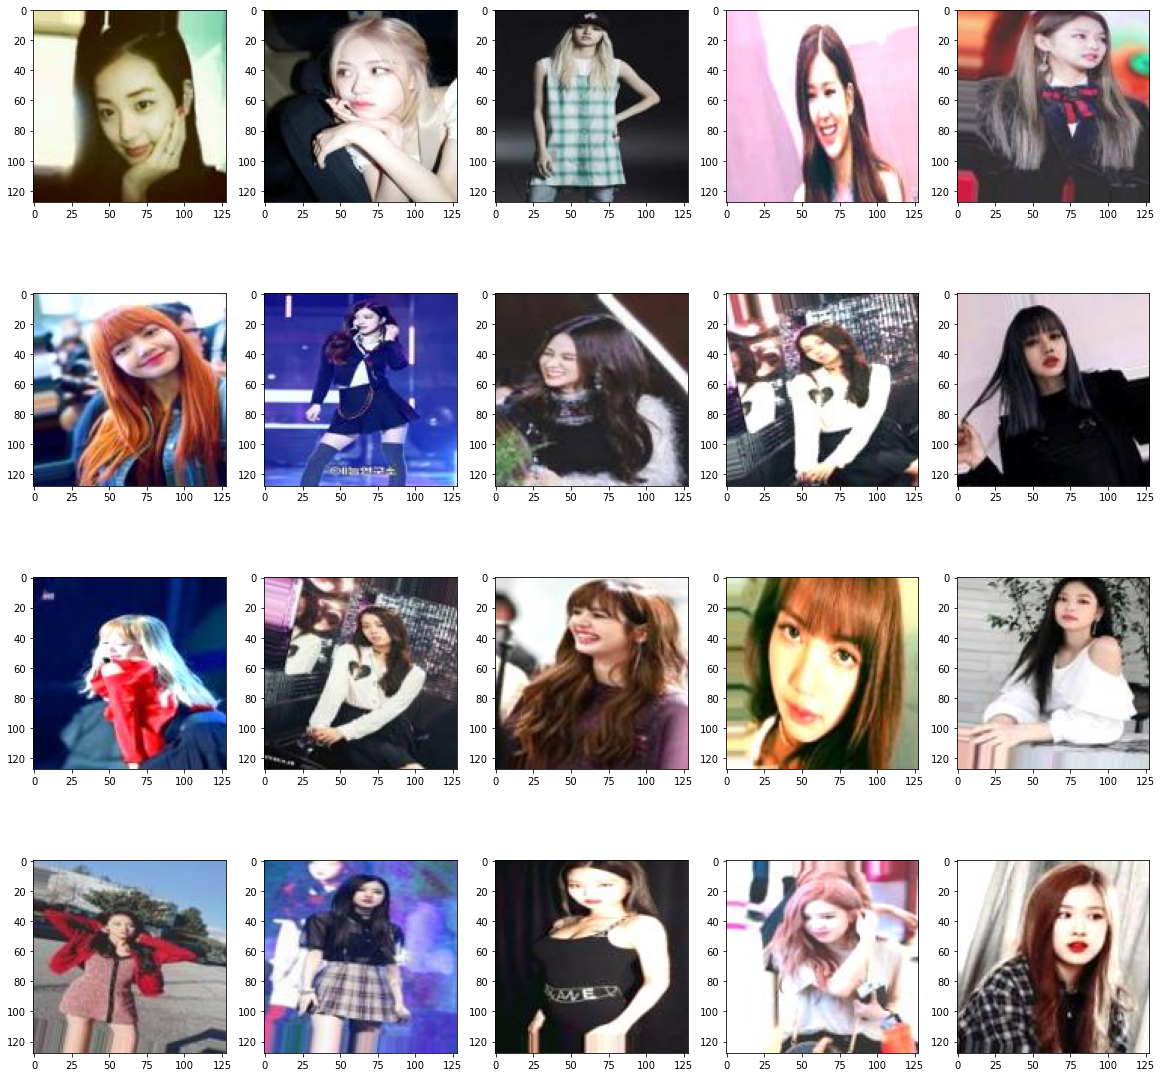

In [13]:
train_data = dataset["train_x"]
train_data_label = dataset["train_y"][0]
show_first_20(train_data,train_data_label)

IMG 1 is labelled 2
IMG 2 is labelled 1
IMG 3 is labelled 2
IMG 4 is labelled 3
IMG 5 is labelled 3
IMG 6 is labelled 2
IMG 7 is labelled 3
IMG 8 is labelled 3
IMG 9 is labelled 0
IMG 10 is labelled 2
IMG 11 is labelled 0
IMG 12 is labelled 0
IMG 13 is labelled 0
IMG 14 is labelled 2
IMG 15 is labelled 2
IMG 16 is labelled 1
IMG 17 is labelled 2
IMG 18 is labelled 3
IMG 19 is labelled 1
IMG 20 is labelled 2


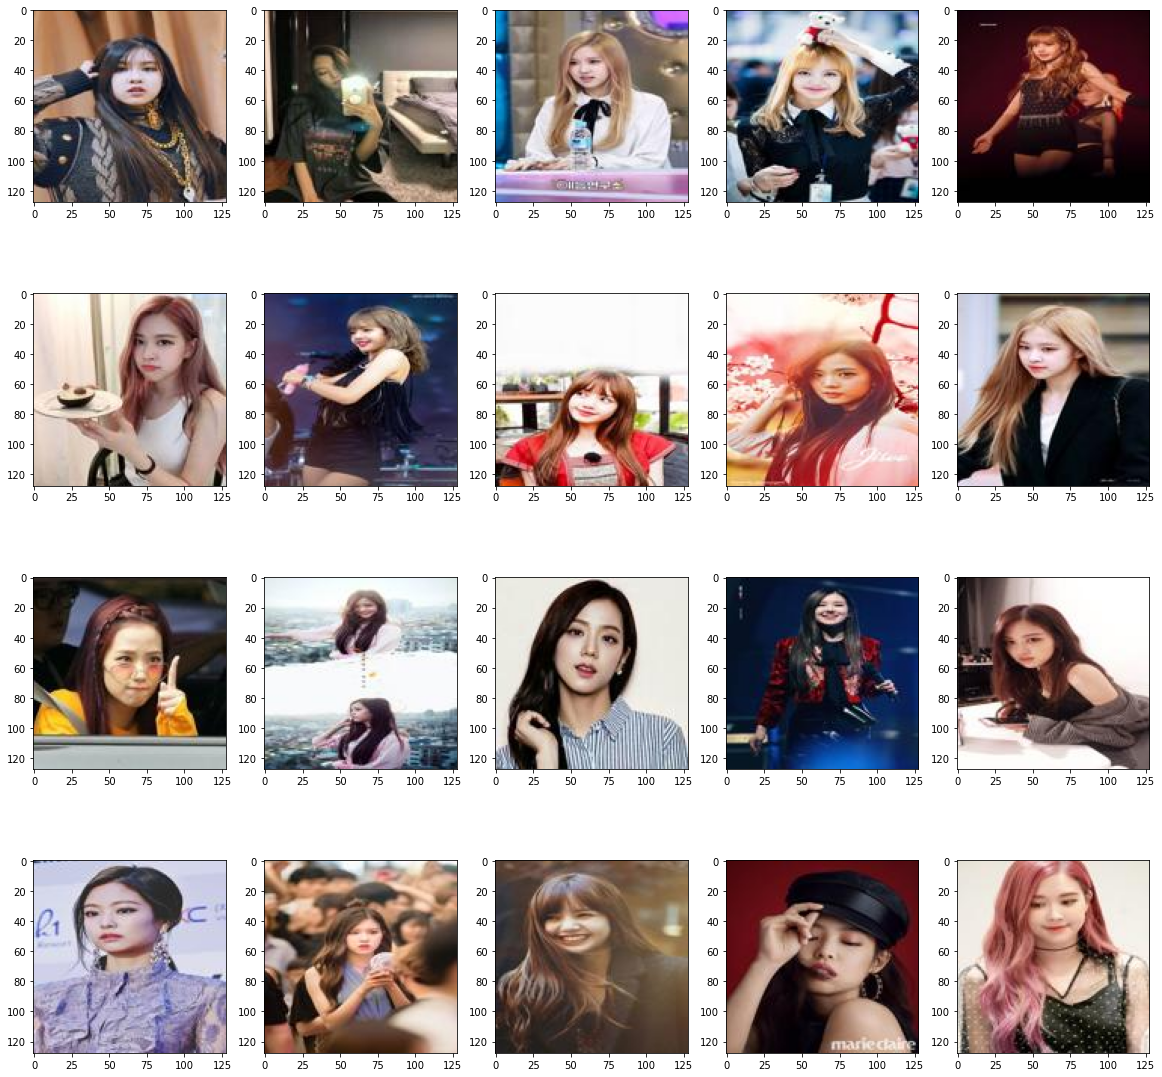

In [14]:
dev_data = dataset["dev_x"]
dev_data_label = dataset["dev_y"][0]
show_first_20(dev_data,dev_data_label)

IMG 1 is labelled 2
IMG 2 is labelled 1
IMG 3 is labelled 2
IMG 4 is labelled 3
IMG 5 is labelled 3
IMG 6 is labelled 2
IMG 7 is labelled 3
IMG 8 is labelled 3
IMG 9 is labelled 0
IMG 10 is labelled 2
IMG 11 is labelled 0
IMG 12 is labelled 0
IMG 13 is labelled 0
IMG 14 is labelled 2
IMG 15 is labelled 2
IMG 16 is labelled 1
IMG 17 is labelled 2
IMG 18 is labelled 3
IMG 19 is labelled 1
IMG 20 is labelled 2


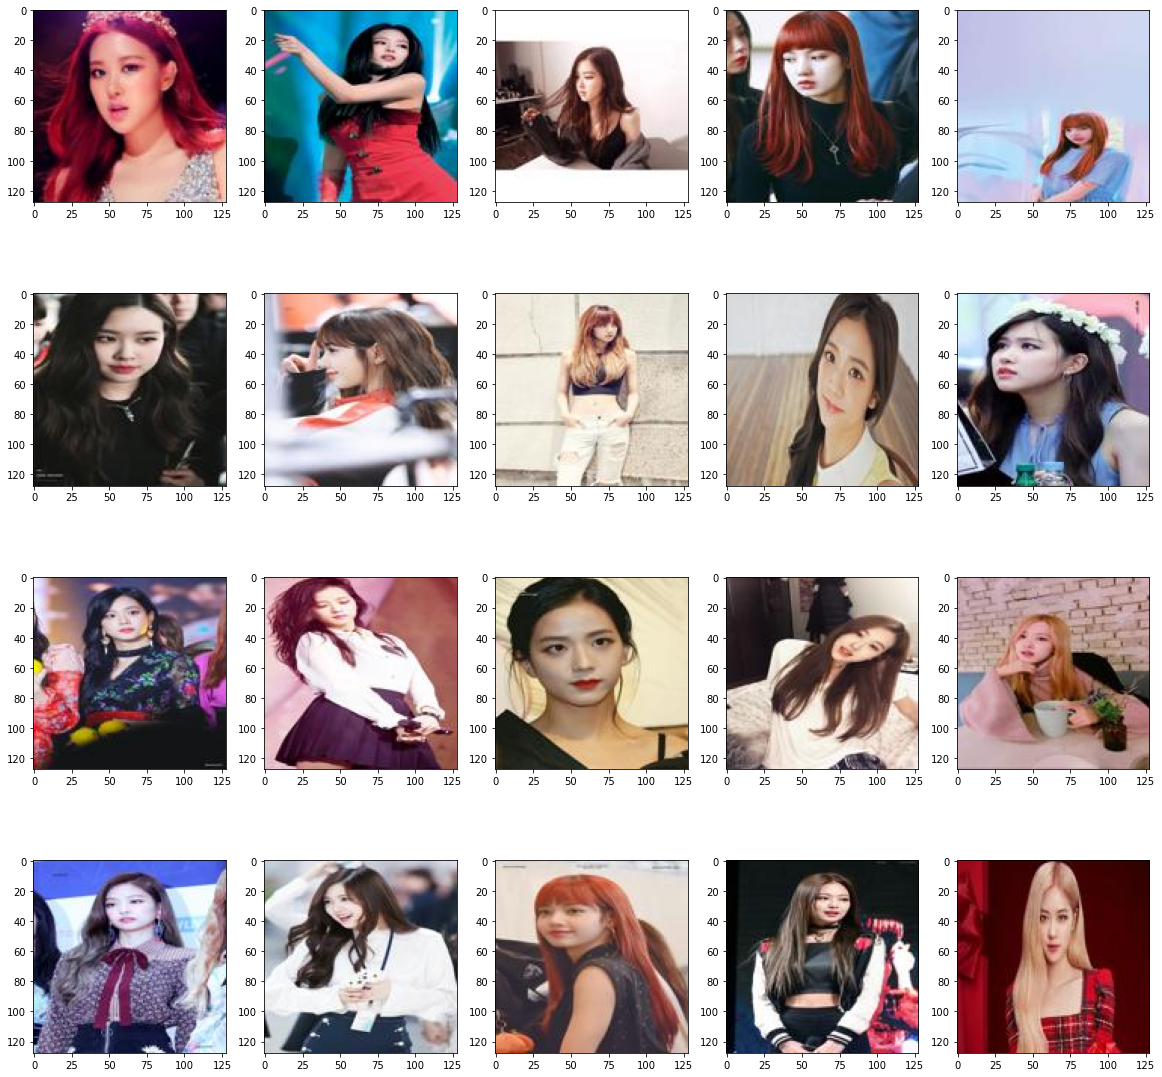

In [15]:
test_data = dataset["test_x"]
test_20_data_label = dataset["test_y"][0]
show_first_20(test_data,test_20_data_label)

## Generate H5 Data

In [16]:
def generate_h5_data(numpy_dataset, subpath, title):

    '''
        Args:
            -- numpy_dataset: numpy dataset that is generated in the previous function
            -- subpath: takes in the subpath of the file directory
            -- title: the .h5 file name that you want as the output
    '''
    
    assert(type(title) is str)
    
    train_filepath =  subpath + f'train_{title}.h5'
    dev_filepath =  subpath + f'dev_{title}.h5'
    test_filepath = subpath + f'test_{title}.h5'
    
    h5train = h5py.File(train_filepath, 'w')
    h5train.create_dataset('train_set_x',data=numpy_dataset["train_x"])
    h5train['train_set_y'] = numpy_dataset["train_y"]
    h5train['train_list_classes'] = numpy_dataset["train_list_classes"]
    
    """DEBUG
    print(h5train['train_set_x'])
    print(h5train['train_set_y'])
    print(h5train['train_list_classes'])
    print(numpy_dataset["train_list_classes"])
    """
    h5train.close()
    
    h5dev = h5py.File(dev_filepath, 'w')
    h5dev.create_dataset('dev_set_x',data=numpy_dataset["dev_x"])
    h5dev['dev_set_y'] = numpy_dataset["dev_y"]
    h5dev['dev_list_classes'] = numpy_dataset["dev_list_classes"]
    
    """DEBUG
    print(h5train['dev_set_x'])
    print(h5dev['dev_set_y'])
    print(h5dev['dev_list_classes'])
    print(numpy_dataset["dev_list_classes"])
    """
    h5dev.close()
    
    h5test = h5py.File(test_filepath, 'w')
    h5test.create_dataset('test_set_x',data=numpy_dataset["test_x"])
    h5test['test_set_y'] = numpy_dataset["test_y"]
    h5test['test_list_classes'] = numpy_dataset["test_list_classes"]
    
    """DEBUG
    print(h5test['test_set_x'])
    print(h5test['test_set_y'])
    print(h5test['test_list_classes'])
    print(numpy_dataset["test_list_classes"])
    """
    h5test.close()

In [17]:
generate_h5_data(dataset,SUB_PATH,H5_FILE_TITLE)

## Review H5 Data

#### To double check if the h5 files are working correctly or not

In [18]:
def review_h5_data(h5filepath,offset=0):
    
    '''
        Args:
            -- h5filepath: .h5 to be read from the directory
            -- offset: default value for the shift in the display of the photos 
    '''
    
    h5file = h5py.File(h5filepath, "r")
    try:
        list_classes_fieldname, x_fieldname, y_fieldname = h5file.keys()
        print("The keys are: ", h5file.keys())
        set_x_orig = np.array(h5file[x_fieldname][:]) # your train/dev/test set features
        set_y_orig = np.array(h5file[y_fieldname][:]) # your train/dev/test set labels
        list_classes_orig = np.array(h5file[list_classes_fieldname][:]) # your train/dev/test set list classes
        print("The shape of x_field",set_x_orig.shape)
        print("The shape of y_field",set_y_orig.shape)
        print("The shape of list_classes_field",list_classes_orig.shape)
        show_first_20(set_x_orig,set_y_orig[0],offset)
    finally:
        h5file.close()

The keys are:  <KeysViewHDF5 ['train_list_classes', 'train_set_x', 'train_set_y']>
The shape of x_field (6792, 128, 128, 3)
The shape of y_field (1, 6792)
The shape of list_classes_field (1, 6792)
IMG 1 is labelled 0
IMG 2 is labelled 2
IMG 3 is labelled 3
IMG 4 is labelled 2
IMG 5 is labelled 1
IMG 6 is labelled 3
IMG 7 is labelled 2
IMG 8 is labelled 0
IMG 9 is labelled 0
IMG 10 is labelled 3
IMG 11 is labelled 3
IMG 12 is labelled 0
IMG 13 is labelled 3
IMG 14 is labelled 3
IMG 15 is labelled 1
IMG 16 is labelled 0
IMG 17 is labelled 2
IMG 18 is labelled 1
IMG 19 is labelled 2
IMG 20 is labelled 2


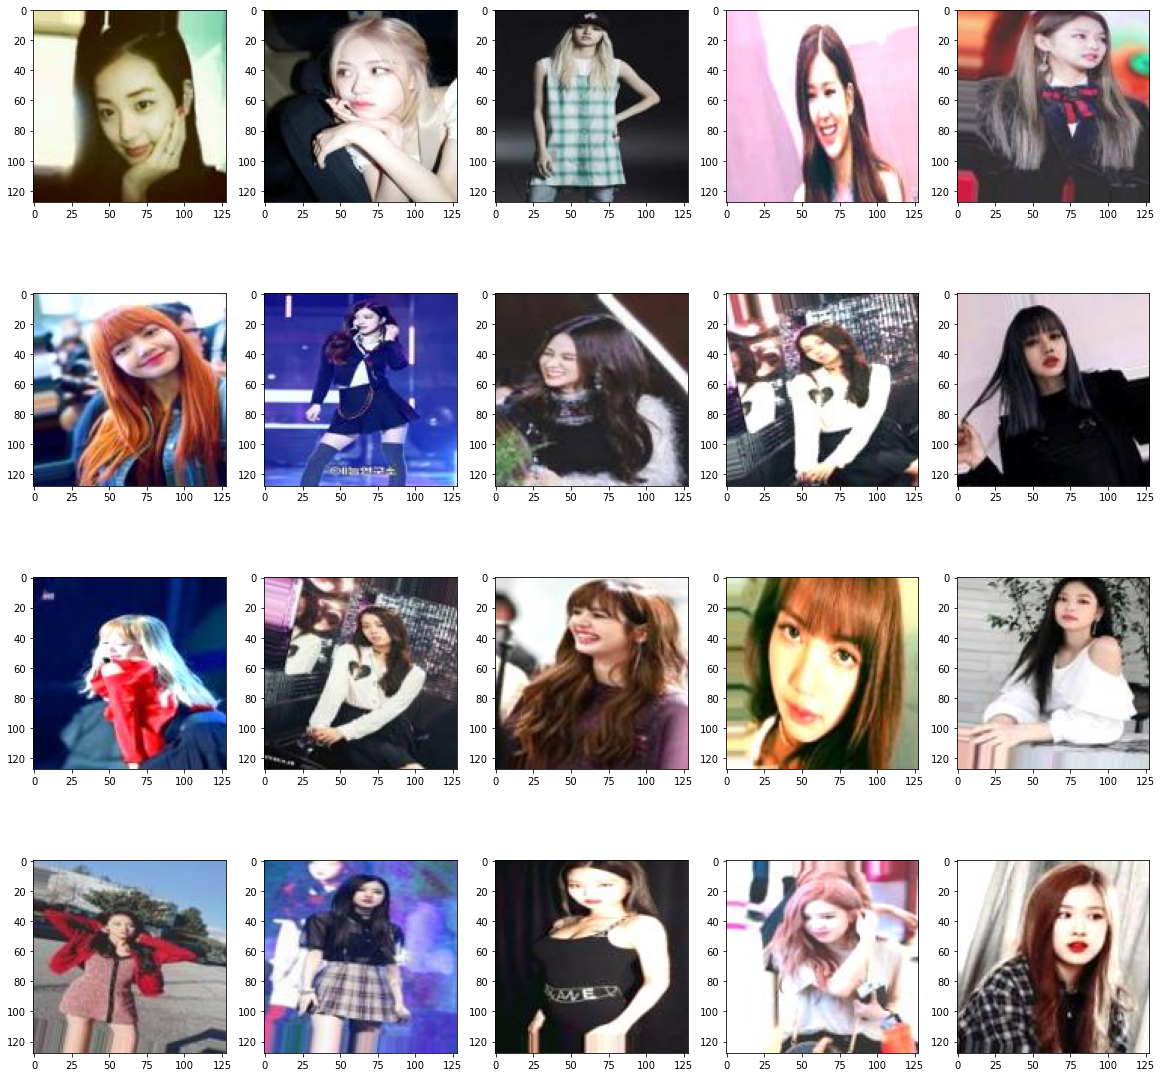

In [19]:
review_h5_data(SUB_PATH + 'train_' + H5_FILE_TITLE + '.h5')

The keys are:  <KeysViewHDF5 ['dev_list_classes', 'dev_set_x', 'dev_set_y']>
The shape of x_field (400, 128, 128, 3)
The shape of y_field (1, 400)
The shape of list_classes_field (1, 400)
IMG 1 is labelled 2
IMG 2 is labelled 1
IMG 3 is labelled 2
IMG 4 is labelled 3
IMG 5 is labelled 3
IMG 6 is labelled 2
IMG 7 is labelled 3
IMG 8 is labelled 3
IMG 9 is labelled 0
IMG 10 is labelled 2
IMG 11 is labelled 0
IMG 12 is labelled 0
IMG 13 is labelled 0
IMG 14 is labelled 2
IMG 15 is labelled 2
IMG 16 is labelled 1
IMG 17 is labelled 2
IMG 18 is labelled 3
IMG 19 is labelled 1
IMG 20 is labelled 2


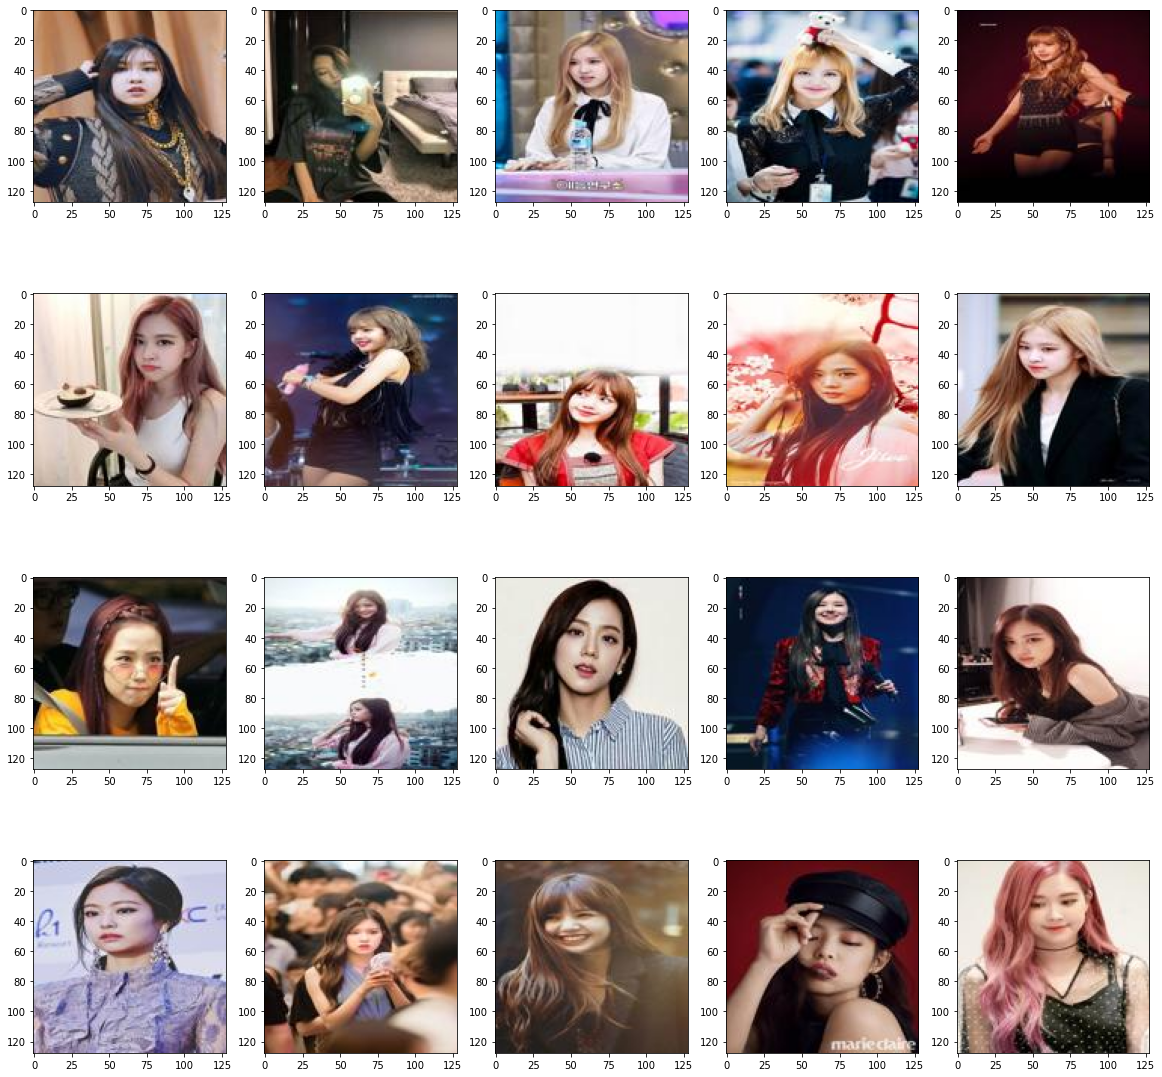

In [20]:
review_h5_data(SUB_PATH + 'dev_' + H5_FILE_TITLE+ '.h5')

The keys are:  <KeysViewHDF5 ['test_list_classes', 'test_set_x', 'test_set_y']>
The shape of x_field (400, 128, 128, 3)
The shape of y_field (1, 400)
The shape of list_classes_field (1, 400)
IMG 1 is labelled 2
IMG 2 is labelled 1
IMG 3 is labelled 2
IMG 4 is labelled 3
IMG 5 is labelled 3
IMG 6 is labelled 2
IMG 7 is labelled 3
IMG 8 is labelled 3
IMG 9 is labelled 0
IMG 10 is labelled 2
IMG 11 is labelled 0
IMG 12 is labelled 0
IMG 13 is labelled 0
IMG 14 is labelled 2
IMG 15 is labelled 2
IMG 16 is labelled 1
IMG 17 is labelled 2
IMG 18 is labelled 3
IMG 19 is labelled 1
IMG 20 is labelled 2


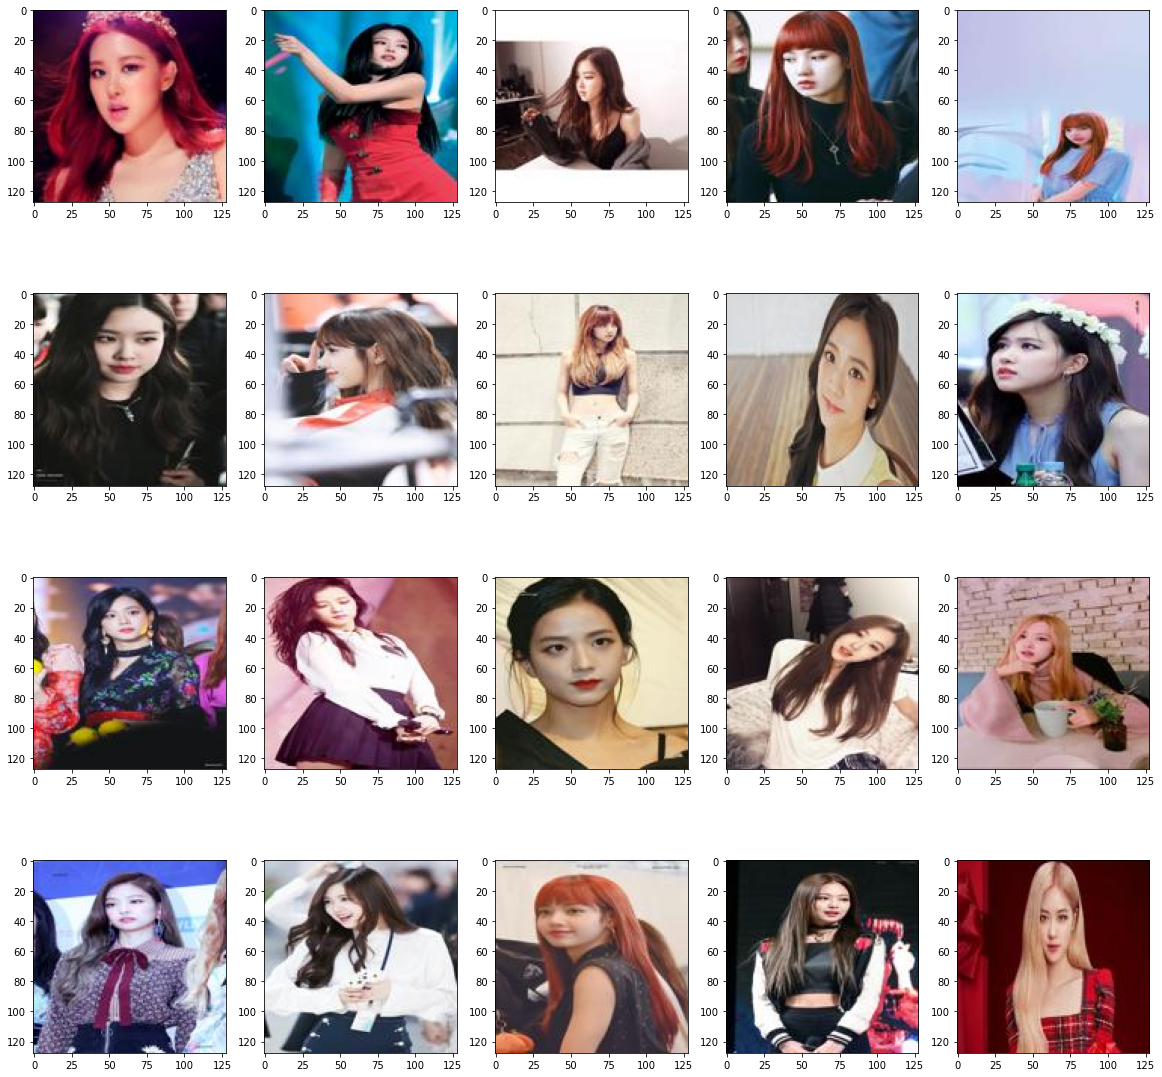

In [21]:
review_h5_data(SUB_PATH + 'test_' + H5_FILE_TITLE + '.h5')